In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import rdkit
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from mordred import Calculator, descriptors
from rdkit.Chem import rdFingerprintGenerator
import matplotlib.pyplot as plt
import umap.umap_ as umap
import umap.plot
from sklearn.cluster import SpectralClustering

In [40]:
df = pd.read_csv("data_compound.csv")
df

,cid,smiles,bioactivity,type,value (nM)
0,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
1,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
2,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
3,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0
4,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0
...,...,...,...,...,...
832,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0
833,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
834,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
835,118159305,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Inactive,IC50,163000.0


In [41]:
df_hist = df[['cid','smiles','bioactivity', 'type', 'value (nM)']]
#df_hist = df_hist[df_hist["bioactivity"] != 'Unspecified']
df_hist

,cid,smiles,bioactivity,type,value (nM)
0,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
1,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
2,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0
3,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0
4,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0
...,...,...,...,...,...
832,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0
833,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
834,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0
835,118159305,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(...,Inactive,IC50,163000.0


In [42]:
IC50_only = df_hist[df_hist['type']=='IC50'].reset_index(drop=True)
IC50_only['pIC50'] = 9 - np.log10(IC50_only['value (nM)'])
IC50_only = IC50_only.drop_duplicates(keep='first', ignore_index=True)
IC50_only

,cid,smiles,bioactivity,type,value (nM),pIC50
0,118159176,C[C@@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3C...,Active,IC50,8300.0,5.080922
1,127024762,C[C@@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C...,Active,IC50,1570.0,5.804100
2,127024157,C[C@@H]1C[C@H]1NC2=NC3=CN=NC=C3N=C2N4CCC(CC4)[...,Active,IC50,145.0,6.838632
3,118159182,C[C@H](C(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CC...,Active,IC50,6600.0,5.180456
4,155525744,C[C@H](CO)NC1=NC2=CC=CC=C2N=C1N3CCN(CC3)CC4=C(...,Active,IC50,1570.0,5.804100
...,...,...,...,...,...,...
435,118159306,CN1CCC2=C(C1)N=C(C(=N2)NC3CC3)N4CCC(CC4)OC5=C(...,Inactive,IC50,145000.0,3.838632
436,118159408,COCC(=O)N1CCC2=C(C1)N=C(C(=N2)NCC(F)F)N3CCC(CC...,Inactive,IC50,79500.0,4.099633
437,118159205,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,49300.0,4.307153
438,118180378,CS(=O)(=O)N1CCC2=C(C1)N=C(C(=N2)N3CCC(CC3)OC4=...,Inactive,IC50,57200.0,4.242604


<Figure size 2000x2000 with 0 Axes>

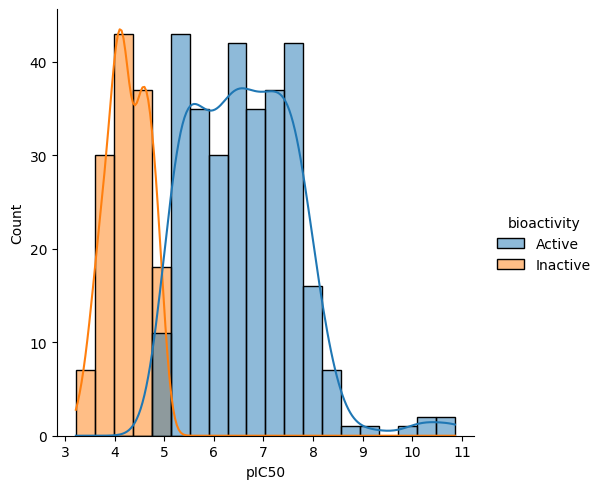

In [43]:
plt.figure(figsize=(20, 20))

sns.displot(IC50_only, bins=20, x='pIC50', hue='bioactivity', kde=True)
plt.show()

In [44]:
def canonical_smiles(smiles):
    mol_smiles = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mol_smiles]

    return smiles

In [45]:
CANNO_SMILES = canonical_smiles(IC50_only.smiles)
len(CANNO_SMILES)

440

In [46]:
IC50_only['smiles'] = CANNO_SMILES
IC50_only

,cid,smiles,bioactivity,type,value (nM),pIC50
0,118159176,CO[C@@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4cc...,Active,IC50,8300.0,5.080922
1,127024762,C[C@@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2C...,Active,IC50,1570.0,5.804100
2,127024157,C[C@@H]1C[C@H]1Nc1nc2cnncc2nc1N1CCC([C@@H](F)c...,Active,IC50,145.0,6.838632
3,118159182,CO[C@H](C)C(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc...,Active,IC50,6600.0,5.180456
4,155525744,C[C@H](CO)Nc1nc2ccccc2nc1N1CCN(Cc2cc(Cl)ccc2Cl...,Active,IC50,1570.0,5.804100
...,...,...,...,...,...,...
435,118159306,COc1ccc(OC2CCN(c3nc4c(nc3NC3CC3)CCN(C)C4)CC2)c...,Inactive,IC50,145000.0,3.838632
436,118159408,COCC(=O)N1CCc2nc(NCC(F)F)c(N3CCC(Oc4ccc(F)cc4F...,Inactive,IC50,79500.0,4.099633
437,118159205,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,49300.0,4.307153
438,118180378,CS(=O)(=O)N1CCc2nc(N3CCC(Oc4ccc(F)cc4F)CC3)c(N...,Inactive,IC50,57200.0,4.242604


In [79]:
IC50_only.to_csv("pIC50.csv", index=False)

Morgan Fingerprint

In [48]:
compounds_morgan = []

for _, smiles, bioactivity, pIC50 in IC50_only[['smiles', 'bioactivity', 'pIC50']].itertuples():
    compounds_morgan.append((Chem.MolFromSmiles(smiles), bioactivity, pIC50))
compounds_morgan[:5]

[(<rdkit.Chem.rdchem.Mol at 0x25fc91178b0>, 'Active', 5.080921907623926),
 (<rdkit.Chem.rdchem.Mol at 0x25fc9116ff0>, 'Active', 5.804100347590767),
 (<rdkit.Chem.rdchem.Mol at 0x25fc9114190>, 'Active', 6.838631997765026),
 (<rdkit.Chem.rdchem.Mol at 0x25fc91173e0>, 'Active', 5.180456064458131),
 (<rdkit.Chem.rdchem.Mol at 0x25fc9114ba0>, 'Active', 5.804100347590767)]

In [49]:
compounds_morgan_structure = pd.DataFrame(compounds_morgan, columns=["Structure", "bioactivity", "pIC50"])
compounds_morgan_structure.head(5)

,Structure,bioactivity,pIC50
0,<rdkit.Chem.rdchem.Mol object at 0x0000025FC91...,Active,5.080922
1,<rdkit.Chem.rdchem.Mol object at 0x0000025FC91...,Active,5.804100
2,<rdkit.Chem.rdchem.Mol object at 0x0000025FC91...,Active,6.838632
3,<rdkit.Chem.rdchem.Mol object at 0x0000025FC91...,Active,5.180456
4,<rdkit.Chem.rdchem.Mol object at 0x0000025FC91...,Active,5.804100


In [50]:
def generate_mfpts(data):
    Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in data]
    return Mfpts

mfpts = generate_mfpts(compounds_morgan_structure.Structure[:])
print("Number of compounds converted:", len(mfpts))
print("Fingerprint length per compound:", len(mfpts[0]))

Number of compounds converted: 440
Fingerprint length per compound: 2048


In [51]:
fp_name_morgan = [f'Bit_{i}' for i in range(2048)]
fp_bits_morgan = [list(l) for l in mfpts]

morganfp_df = pd.DataFrame(fp_bits_morgan, index=IC50_only["bioactivity"], columns=fp_name_morgan)
morganfp_df.reset_index(inplace=True)  # Reset index to bring "cid" back as a column
morganfp_df.rename(columns={"index": "bioactivity"})# Rename the index column to "cid"
morganfp_df.head()

,bioactivity,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Active,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [52]:
morganfp_df_umap = morganfp_df.iloc[:, 1:]
morganfp_df_umap

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
436,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
437,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
438,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


RDK5 Fingerprint

In [53]:
compounds_rdk5 = []

for _, smiles, bioactivity in IC50_only[['smiles', 'bioactivity']].itertuples():
    compounds_rdk5.append((Chem.MolFromSmiles(smiles), bioactivity))
compounds_rdk5[:5]

[(<rdkit.Chem.rdchem.Mol at 0x25fc3bcab20>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x25fc3bca810>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x25fc3bc98c0>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x25fc3bcaf80>, 'Active'),
 (<rdkit.Chem.rdchem.Mol at 0x25fc3bcac70>, 'Active')]

In [54]:
compound_rdk5_structure = pd.DataFrame(compounds_rdk5, columns=["Structure", "bioactivity"])
compound_rdk5_structure

,Structure,bioactivity
0,<rdkit.Chem.rdchem.Mol object at 0x0000025FC3B...,Active
1,<rdkit.Chem.rdchem.Mol object at 0x0000025FC3B...,Active
2,<rdkit.Chem.rdchem.Mol object at 0x0000025FC3B...,Active
3,<rdkit.Chem.rdchem.Mol object at 0x0000025FC3B...,Active
4,<rdkit.Chem.rdchem.Mol object at 0x0000025FC3B...,Active
...,...,...
435,<rdkit.Chem.rdchem.Mol object at 0x0000025FC97...,Inactive
436,<rdkit.Chem.rdchem.Mol object at 0x0000025FC97...,Inactive
437,<rdkit.Chem.rdchem.Mol object at 0x0000025FC97...,Inactive
438,<rdkit.Chem.rdchem.Mol object at 0x0000025FC97...,Inactive


In [55]:
def generate_rdk5(data):
    rdk5_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
    rdk5_fingerprint = [rdk5_gen.GetFingerprint(mol) for mol in data]
    return rdk5_fingerprint

rdk5fp = generate_rdk5(compound_rdk5_structure.Structure[:])
print("Number of compounds converted:", len(rdk5fp))
print("Fingerprint length per compound:", len(rdk5fp[0]))

Number of compounds converted: 440
Fingerprint length per compound: 2048


In [56]:
fp_name_rdk5 = [f'Bit_{i}' for i in range(2048)]
fp_bits_rdk5 = [list(l) for l in rdk5fp]

rdk5_df = pd.DataFrame(fp_bits_rdk5, index=IC50_only["bioactivity"], columns=fp_name_rdk5)
rdk5_df.reset_index(inplace=True)  # Reset index to bring "cid" back as a column
rdk5_df.rename(columns={"index": "bioactivity"})# Rename the index column to "cid"
rdk5_df.head()

,bioactivity,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,Active,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,Active,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [57]:
rdk5_df_umap = rdk5_df.iloc[:, 1:]
rdk5_df_umap

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_2038,Bit_2039,Bit_2040,Bit_2041,Bit_2042,Bit_2043,Bit_2044,Bit_2045,Bit_2046,Bit_2047
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,1
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
436,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
437,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
438,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


 UMAP Morgan Fingerprint

In [58]:
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=5
                    )

In [59]:
data_umap_morgan = umapper.fit_transform(morganfp_df_umap)


In [60]:
data_umap_morgan_x = pd.DataFrame(data_umap_morgan[:, 0], columns = ['x'])
data_umap_morgan_y = pd.DataFrame(data_umap_morgan[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(morganfp_df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_morgan = pd.concat([bioactivity, data_umap_morgan_x, data_umap_morgan_y], axis = 1)
plot_umap_morgan

,bioactivity,x,y
0,Active,0.830803,-1.193452
1,Active,19.415817,-1.824005
2,Active,13.965911,-1.826455
3,Active,0.851144,-1.173422
4,Active,19.364408,-1.898121
...,...,...,...
435,Inactive,1.854506,0.545096
436,Inactive,1.150608,-1.015236
437,Inactive,1.027288,-0.095898
438,Inactive,0.867178,-0.257163


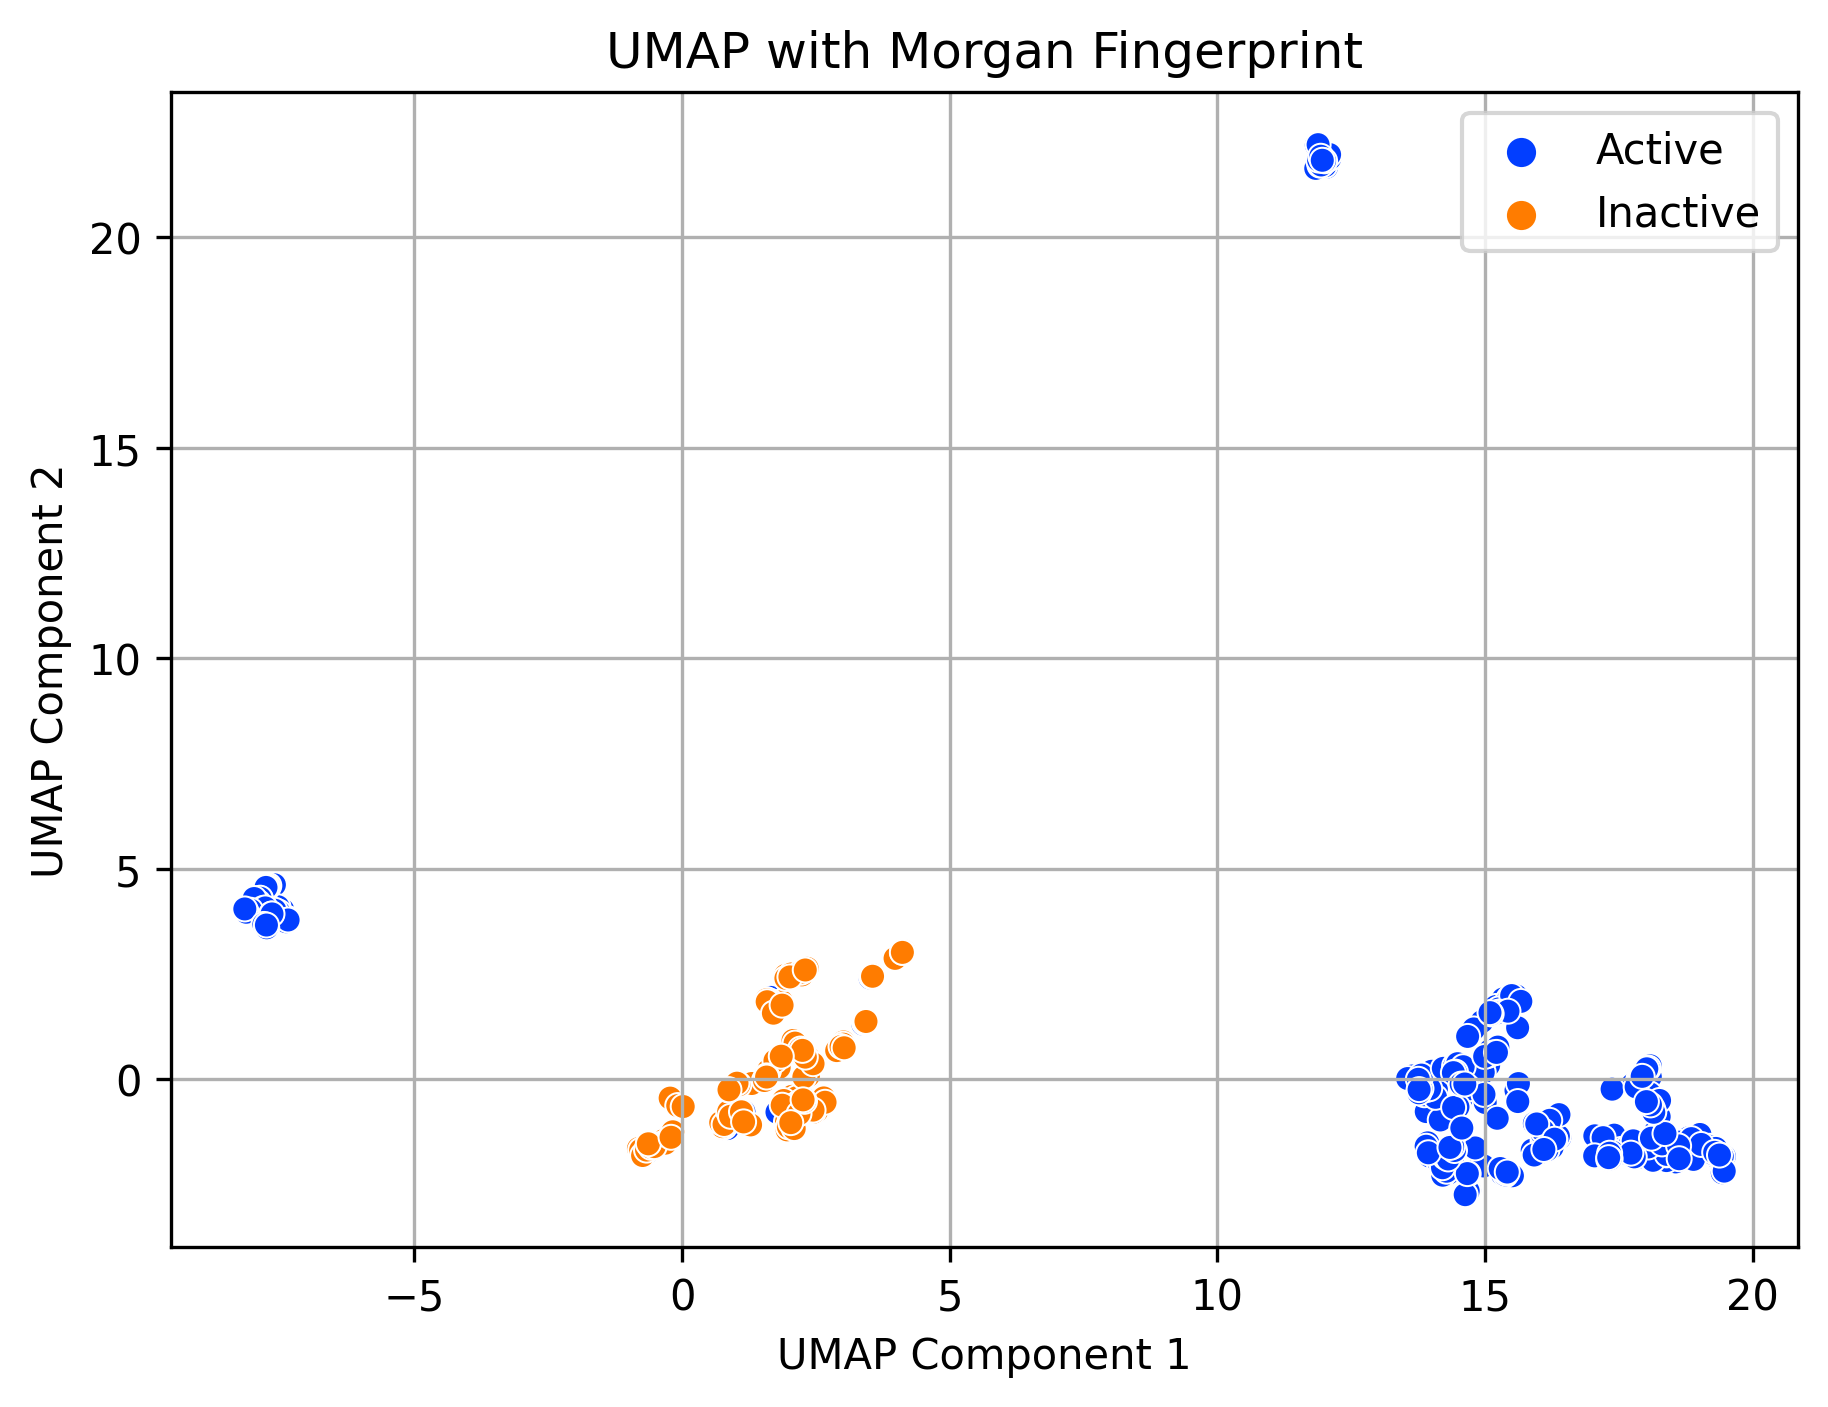

In [61]:
plt.figure(figsize = (7, 5), dpi=300)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_morgan, palette='bright')
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.grid()
plt.legend()
plt.title('UMAP with Morgan Fingerprint', fontsize=12)
plt.show()

UMAP with RDK5 Fingerprint

In [62]:
umapper = umap.UMAP(n_neighbors=50, 
                    n_components=2,
                    metric='euclidean', 
                    random_state=42,
                    )

In [63]:
data_umap_rdk5 = umapper.fit_transform(rdk5_df_umap)

In [64]:
data_umap_rdk5_x = pd.DataFrame(data_umap_rdk5[:, 0], columns = ['x'])
data_umap_rdk5_y = pd.DataFrame(data_umap_rdk5[:, 1], columns = ['y'])
bioactivity = pd.DataFrame(rdk5_df["bioactivity"].values, columns = ['bioactivity'])
plot_umap_rdk5 = pd.concat([bioactivity, data_umap_rdk5_x, data_umap_rdk5_y], axis = 1)
plot_umap_rdk5

,bioactivity,x,y
0,Active,12.724579,-4.951722
1,Active,6.794364,15.381039
2,Active,16.531754,14.826365
3,Active,12.771355,-5.016052
4,Active,6.608349,15.365374
...,...,...,...
435,Inactive,14.249720,-3.874326
436,Inactive,12.667703,-4.827336
437,Inactive,14.414190,-2.525538
438,Inactive,14.434322,-2.484418


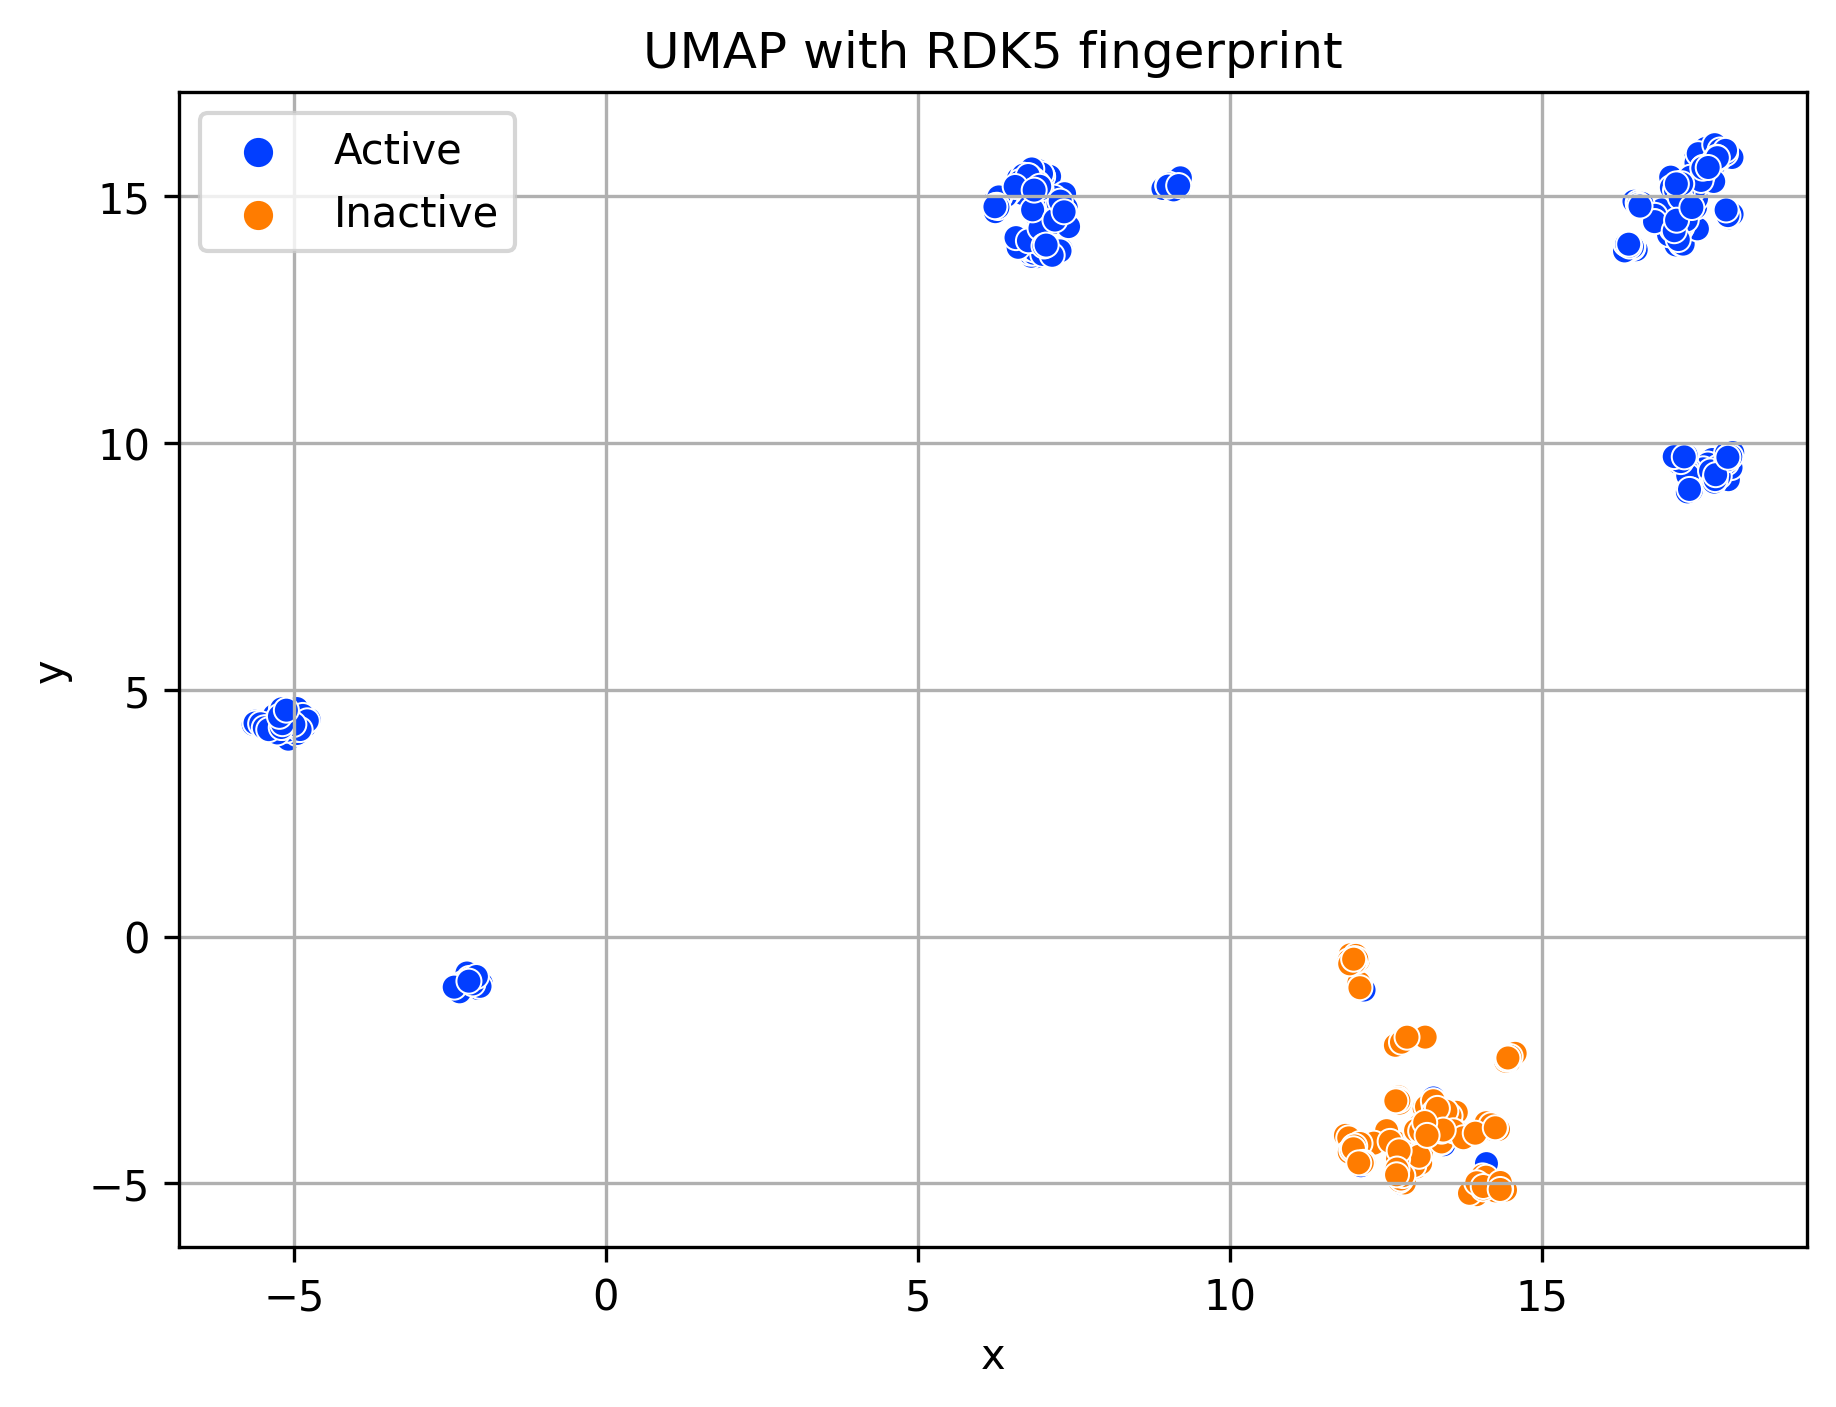

In [65]:
plt.figure(figsize = (7, 5), dpi=300)
sns.scatterplot(x='x', y='y', hue='bioactivity', data=plot_umap_rdk5, palette='bright')
plt.grid()
plt.legend()
plt.title('UMAP with RDK5 fingerprint', fontsize=12)
plt.show()

Clustering by Butina of Morgan FP

In [66]:
from rdkit.ML.Cluster import Butina

In [67]:
def tanimoto_distance_matrix(fp_list):
    
    dissimilarity_matrix = []
    
    for i in range(1, len(fp_list)):
        
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [68]:
sim = DataStructs.TanimotoSimilarity(mfpts[0], mfpts[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.24, distance: 0.76


In [69]:
tanimoto_distance_matrix(mfpts)

[0.7572815533980582,
 0.6734693877551021,
 0.6808510638297872,
 0.0,
 0.7572815533980582,
 0.6734693877551021,
 0.7572815533980582,
 0.0,
 0.6808510638297872,
 0.7572815533980582,
 0.7821782178217822,
 0.7,
 0.7340425531914894,
 0.7821782178217822,
 0.7,
 0.5813953488372092,
 0.7916666666666666,
 0.611764705882353,
 0.5813953488372092,
 0.7916666666666666,
 0.6463414634146342,
 0.7647058823529411,
 0.2857142857142857,
 0.6739130434782609,
 0.7647058823529411,
 0.2857142857142857,
 0.6627906976744187,
 0.7608695652173914,
 0.7264150943396226,
 0.6276595744680851,
 0.6063829787234043,
 0.7264150943396226,
 0.6276595744680851,
 0.6521739130434783,
 0.6333333333333333,
 0.5888888888888889,
 0.7037037037037037,
 0.7358490566037736,
 0.4367816091954023,
 0.7037037037037037,
 0.7358490566037736,
 0.696969696969697,
 0.6086956521739131,
 0.7184466019417476,
 0.4838709677419355,
 0.7037037037037037,
 0.7358490566037736,
 0.4367816091954023,
 0.7037037037037037,
 0.7358490566037736,
 0.696969696

In [70]:
n = len(mfpts)

elem_triangular_matr = (n * (n - 1)) / 2

print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(mfpts) ({len(tanimoto_distance_matrix(mfpts))})",
)

Elements in the triangular matrix (96580) == tanimoto_distance_matrix(mfpts) (96580)


In [71]:
def cluster_mfpts(fingerprints, cutoff=0.3):

    distance_matrix = tanimoto_distance_matrix(mfpts)
    clusters = Butina.ClusterData(distance_matrix, len(mfpts), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

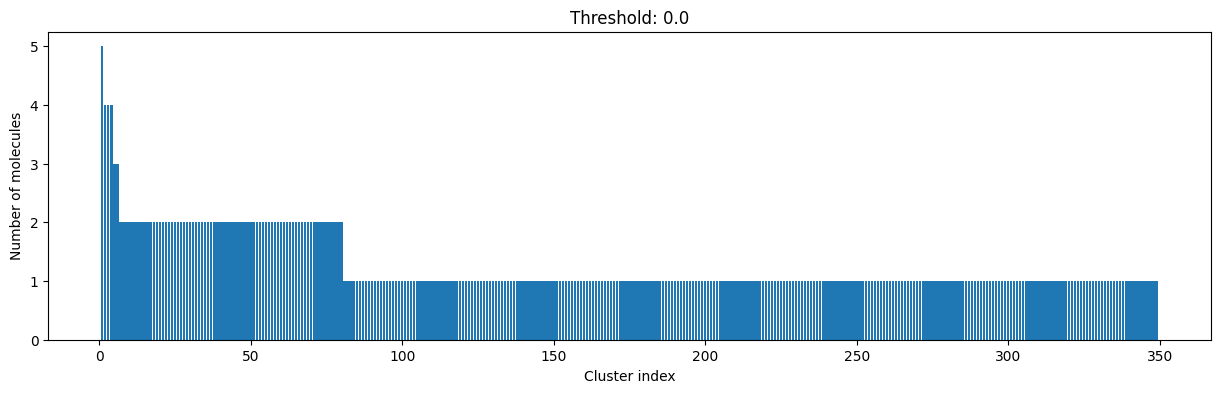

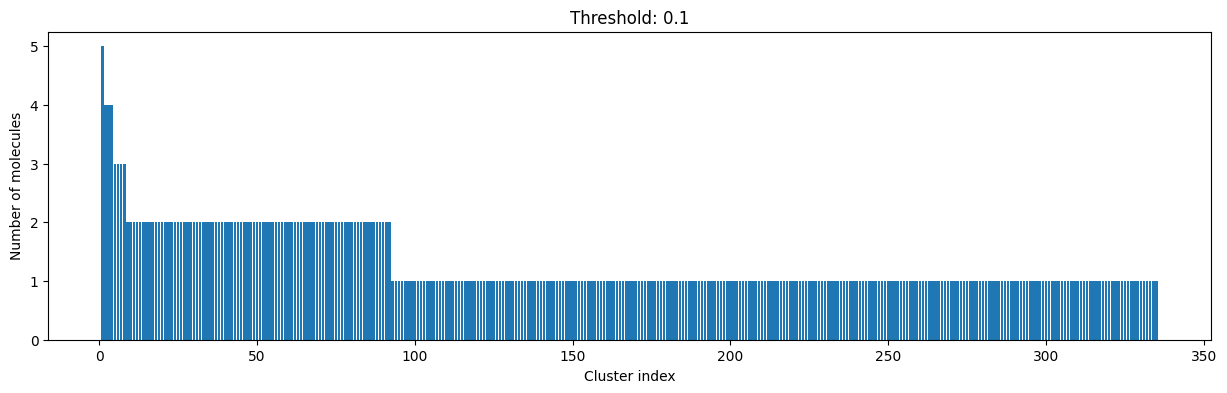

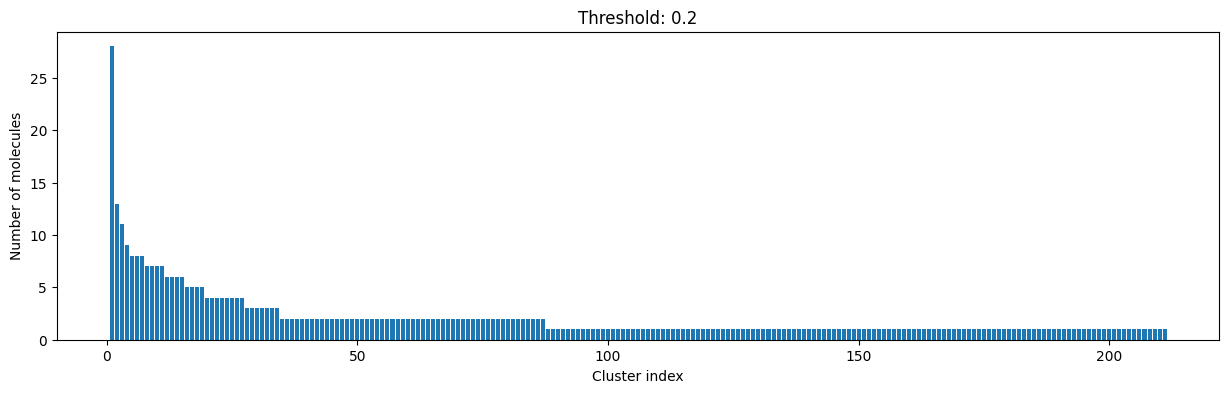

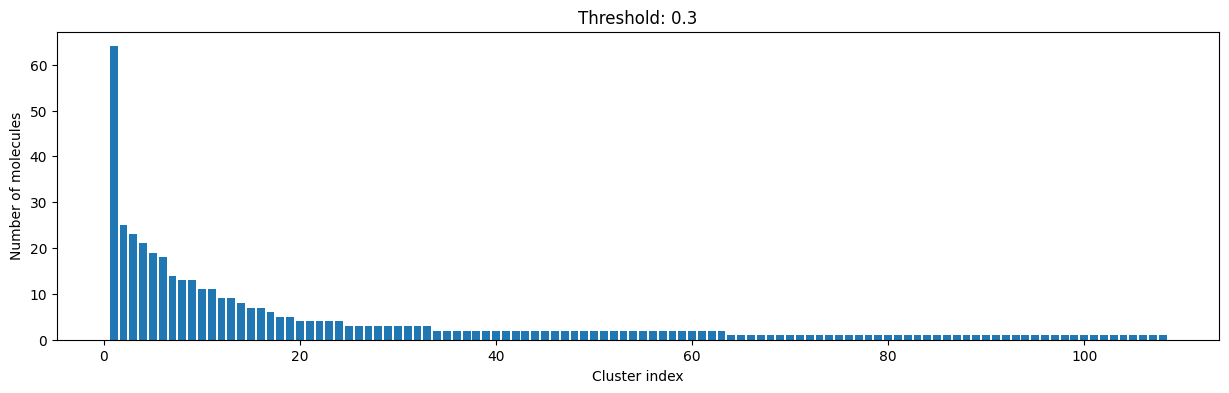

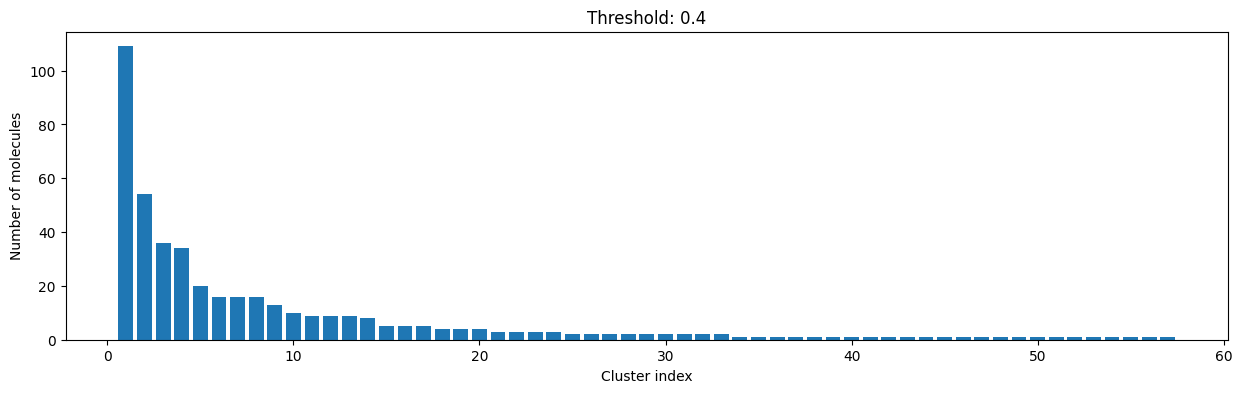

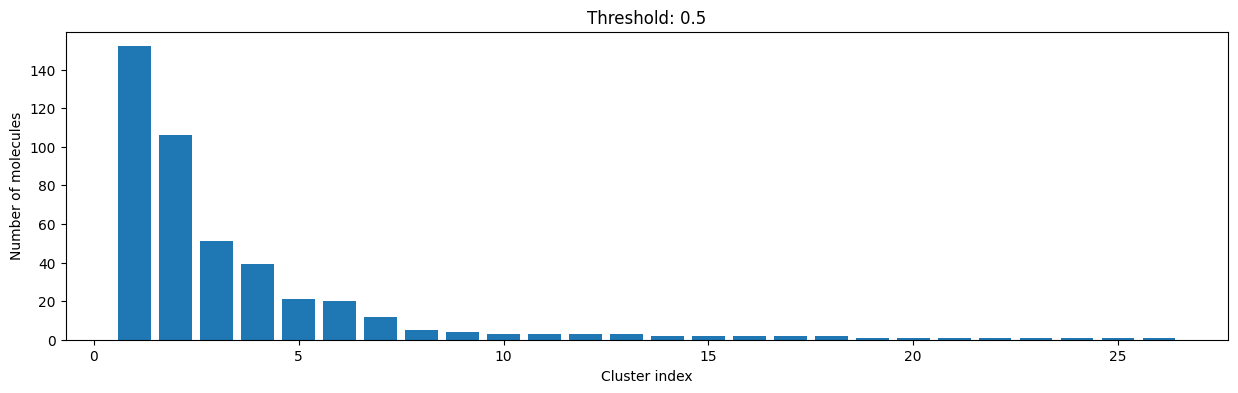

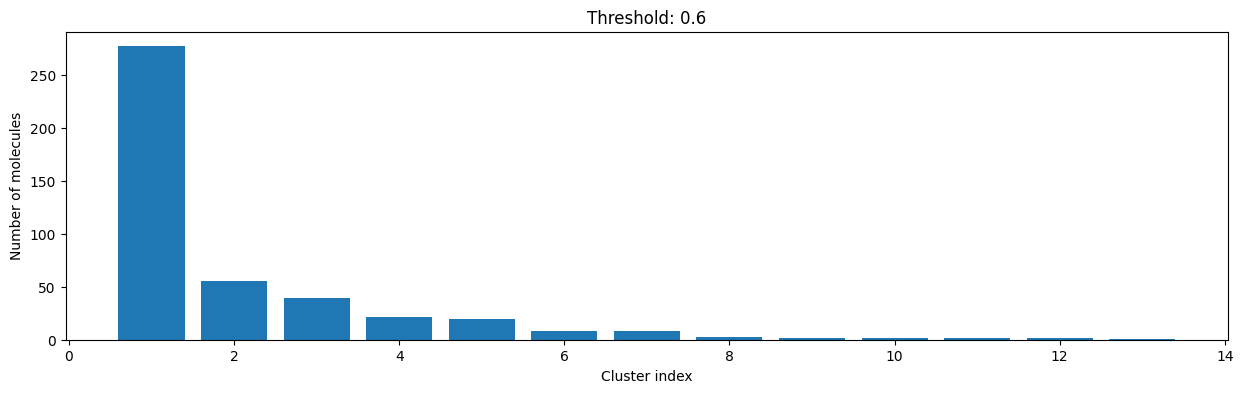

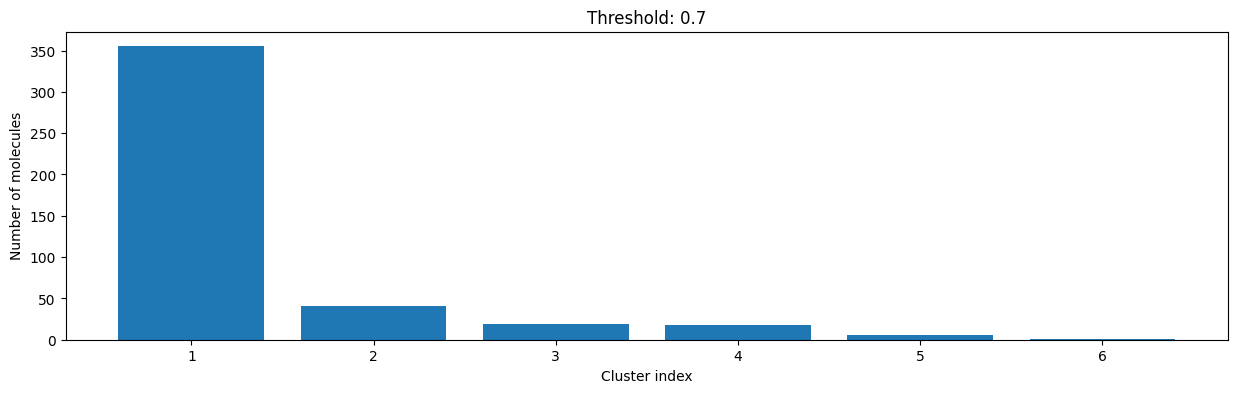

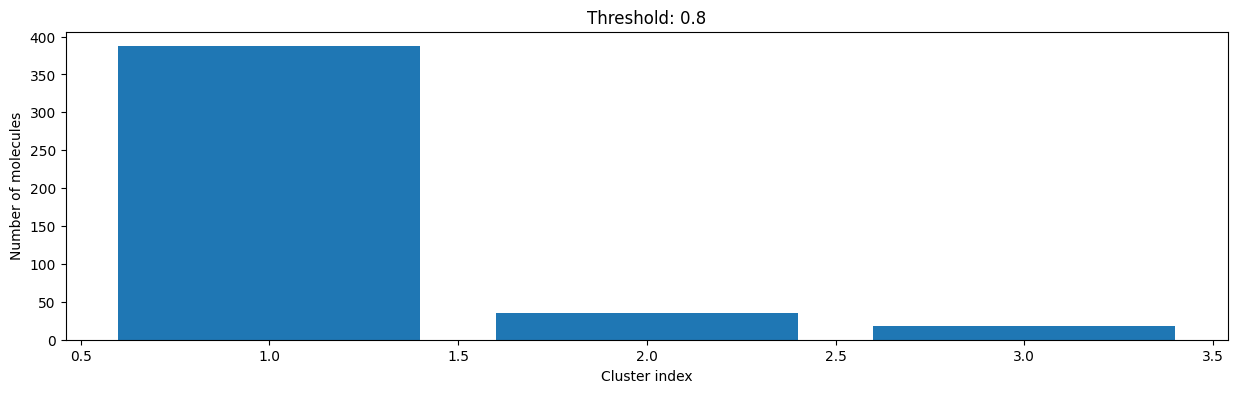

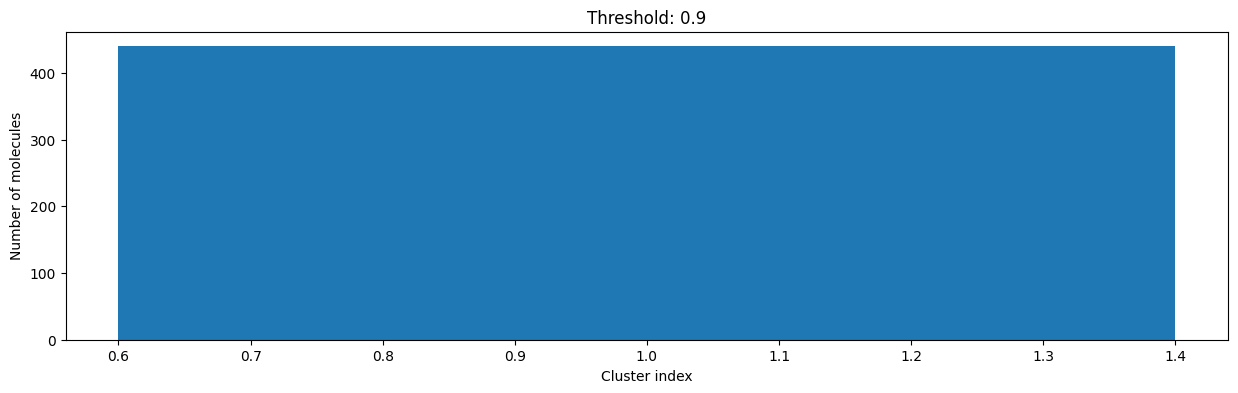

In [72]:
for cutoff in np.arange(0.0, 1.0, 0.1):
    clusters = cluster_mfpts(mfpts, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    plt.show()

In [73]:
from sklearn.decomposition import PCA

In [74]:
data_umap_morgan

array([[ 8.30802500e-01, -1.19345212e+00],
       [ 1.94158173e+01, -1.82400489e+00],
       [ 1.39659109e+01, -1.82645464e+00],
       [ 8.51144135e-01, -1.17342222e+00],
       [ 1.93644085e+01, -1.89812076e+00],
       [ 1.77553654e+01, -1.31021306e-01],
       [ 1.47447987e+01, -4.45968509e-02],
       [ 1.92549381e+01, -1.76586270e+00],
       [ 1.72677479e+01, -1.66904521e+00],
       [ 1.43307228e+01, -1.94429100e+00],
       [ 1.43922348e+01, -1.95541966e+00],
       [ 1.48997583e+01, -3.97677094e-01],
       [ 1.85467129e+01, -1.88008821e+00],
       [ 1.49007196e+01, -2.07530499e+00],
       [ 1.50035515e+01, -2.06986046e+00],
       [ 1.64009151e+01, -1.38711107e+00],
       [ 1.73771038e+01, -2.37759963e-01],
       [ 1.50058222e+01, -5.54829538e-01],
       [ 1.88085556e+01, -1.39252472e+00],
       [ 1.74156647e+01, -1.33039880e+00],
       [ 1.80301991e+01,  2.62578219e-01],
       [ 1.80900173e+01,  3.16796094e-01],
       [ 1.78766689e+01, -4.29556519e-03],
       [ 1.

Plot Each Clusters by UMAP

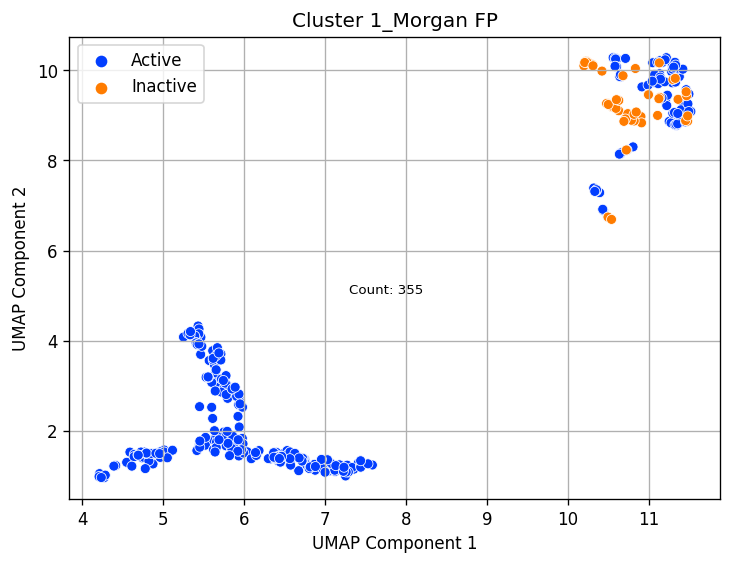

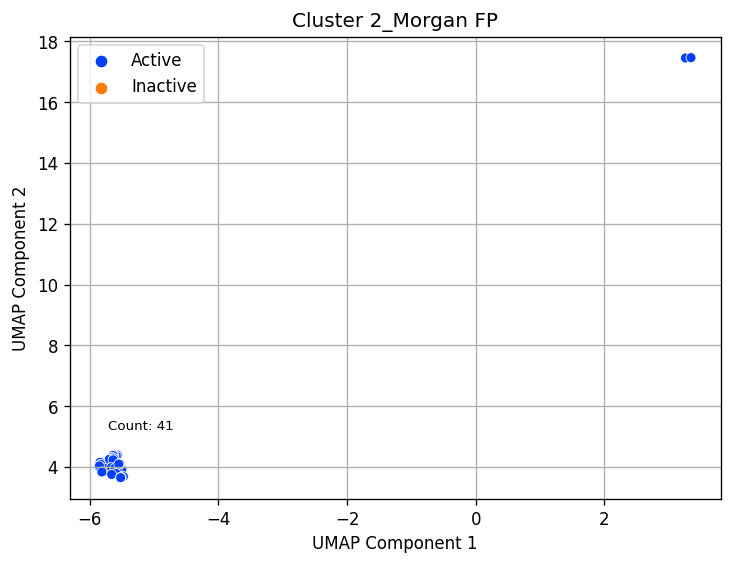

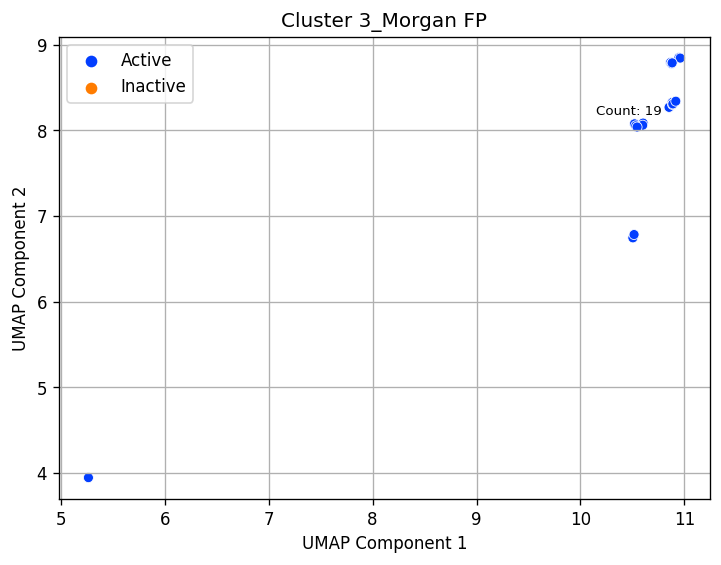

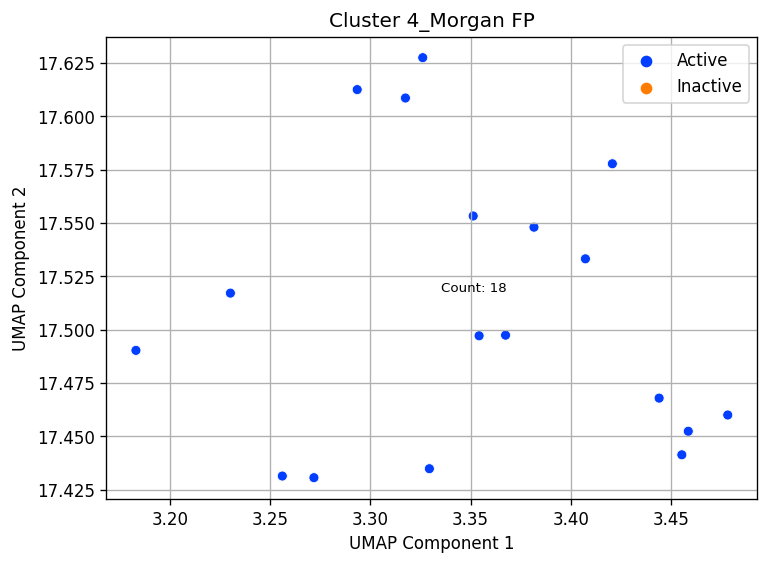

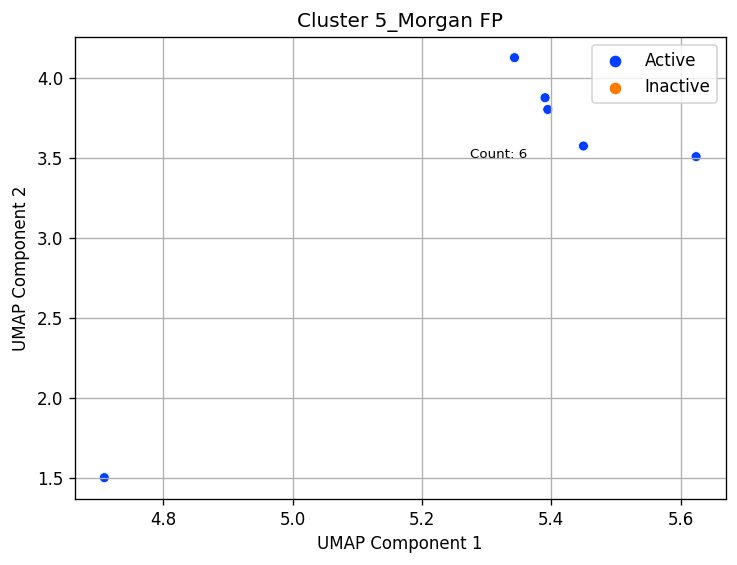

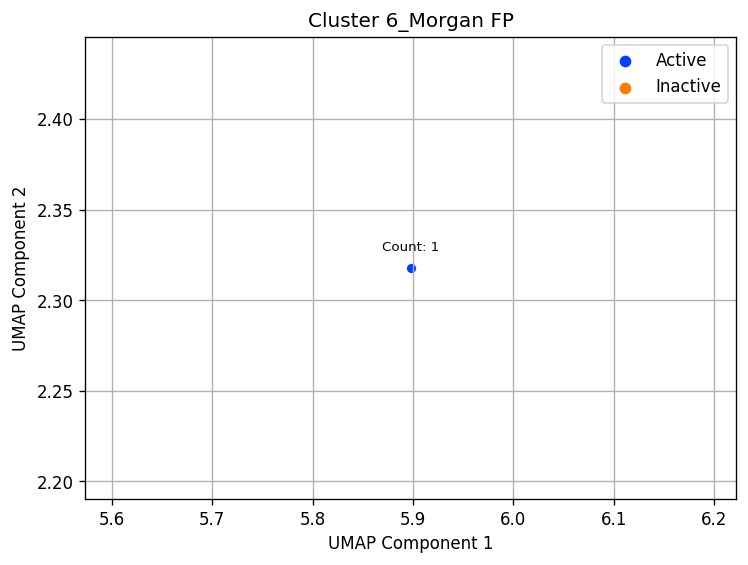

In [75]:
# Start with UMAP
umapper = umap.UMAP(n_neighbors=20, 
                    n_components=5,
                    metric='euclidean',
                    random_state=5
                    )

data_umap_morgan = umapper.fit_transform(morganfp_df_umap)

# Apply Butina functions
cutoff = 0.7
clusters = cluster_mfpts(data_umap_morgan, cutoff=cutoff)


# Create a scatter plot using Seaborn
for cluster_index, cluster in enumerate(clusters, start=1):
    cluster_molecule_indices = cluster 
    
    cluster_coords = data_umap_morgan[cluster_molecule_indices, :]
    
    x_coords = cluster_coords[:, 0]
    y_coords = cluster_coords[:, 1]
    
    cluster_labels = np.full(len(cluster_molecule_indices), f"Cluster {cluster_index}")
    
    
    data_umap_morgan_x = pd.DataFrame(x_coords, columns = ['x'])
    data_umap_morgan_y = pd.DataFrame(y_coords, columns = ['y'])
    bioactivity = pd.DataFrame(morganfp_df["bioactivity"].values, columns = ['bioactivity'])
    plot_umap_morgan_butina = pd.concat([bioactivity, data_umap_morgan_x, data_umap_morgan_y], axis = 1)
    plot_umap_morgan_butina
    
    plt.figure(figsize=(7, 5), dpi=120)
    sns.scatterplot(x="x", y="y", hue='bioactivity' , data=plot_umap_morgan_butina, palette='bright')
    plt.xlabel("UMAP Component 1")
    plt.ylabel("UMAP Component 2")
    plt.title(f"Cluster {cluster_index}_Morgan FP")
    
    cluster_size = len(cluster_molecule_indices)
    mean_x = np.mean(data_umap_morgan[cluster_molecule_indices, 0])
    mean_y = np.mean(data_umap_morgan[cluster_molecule_indices, 1])
    plt.annotate(f"Count: {cluster_size}", (mean_x, mean_y), xytext=(0, 10),textcoords="offset points", ha='center', fontsize=8)

    plt.legend()
    plt.grid()
    plt.show()

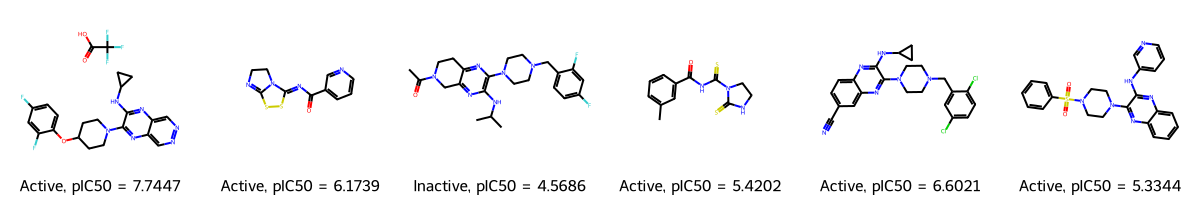

In [76]:
Draw.MolsToGridImage(
    [compounds_morgan_structure["Structure"][clusters[i][0]] for i in range(6)],
    molsPerRow=6,
    legends=[
        f"{compounds_morgan_structure['bioactivity'][clusters[i][0]]}, pIC50 = {compounds_morgan_structure['pIC50'][clusters[i][0]]:.4f}"
        for i in range(6)]
)